In [76]:
import sys
import os
import librosa
from matplotlib import pyplot as plt

# Add custom path (if required)
sys.path.append('..')

# Import custom functions from libfmp
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4

# Ensure matplotlib displays inline in Jupyter
%matplotlib inline

# Define file path
fn_wav = r'\01. Vitalic.flac'

# Check if the audio file exists
if not os.path.exists(fn_wav):
    print(f"File not found: {fn_wav}")
else:
    print(f"File exists: {fn_wav}")

# Load audio manually using librosa
try:
    x, Fs_X = librosa.load(fn_wav, sr=None)  # sr=None keeps the original sample rate
    print(f"Audio loaded successfully with sample rate: {Fs_X}")
except Exception as e:
    print(f"Error loading audio file: {e}")

# Compute tempo (set) relative range
tempo_rel_set = libfmp.c4.compute_tempo_rel_set(0.66, 1.5, 5)

# Feature extraction (with error handling)
try:
    # Manually pass the audio signal 'x' and sampling rate 'Fs_X' to the feature extraction function
    x_duration = len(x) / Fs_X  # Duration in seconds
    X, S, I = libfmp.c4.compute_sm_from_filename(fn_wav, L=81, H=10, L_smooth=1, thresh=1)
    print("Audio features computed successfully!")
except Exception as e:
    print(f"Error in feature extraction: {e}")

# Convert structure annotation (with error handling)
try:
    ann_frames = libfmp.c4.convert_structure_annotation(ann=S, Fs=Fs_X)
except Exception as e:
    print(f"Error in structure annotation: {e}")

# Plot the feature matrix and annotations (with error handling)
try:
    fig, ax = libfmp.c4.plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X,
                                         label='Time (frames)', clim_X=[0, 1], clim=[0, 1],
                                         title='Feature rate: %0.0f Hz' % (Fs_X))
    plt.show()  # Ensure the plot is displayed in Jupyter
except Exception as e:
    print(f"Error in visualization: {e}")


File exists: C:\Users\nield\Desktop\GitHub\Music-Structure-Analysis\DO NOT TOUCH\Audio Files\Emmanuel\01. Vitalic.flac
Audio loaded successfully with sample rate: 44100
Error in feature extraction: load() takes 1 positional argument but 2 were given
Error in visualization: name 'X' is not defined


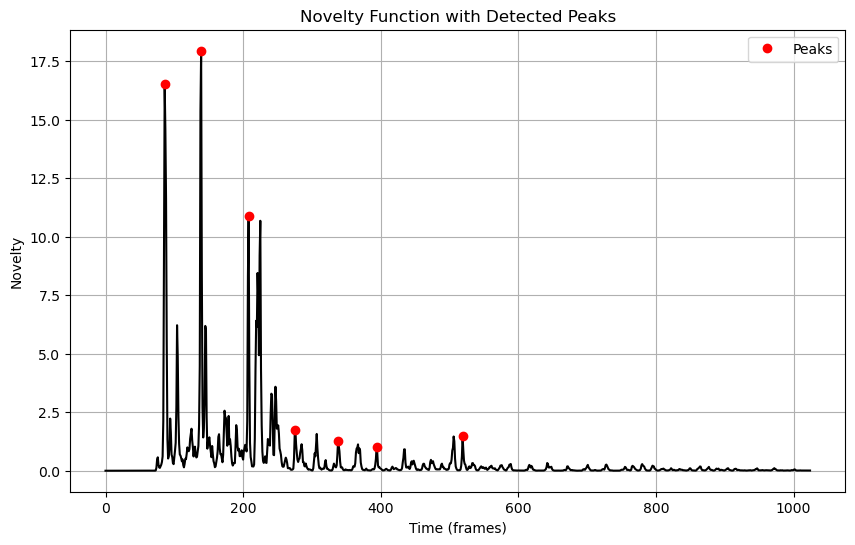

Detected peaks (segments):
Peak at 0.9985 seconds, Novelty value: 16.5101
Peak at 1.6138 seconds, Novelty value: 17.9492
Peak at 2.4149 seconds, Novelty value: 10.8918
Peak at 3.2044 seconds, Novelty value: 1.7269
Peak at 3.9242 seconds, Novelty value: 1.2818
Peak at 4.5743 seconds, Novelty value: 1.0106
Peak at 6.0256 seconds, Novelty value: 1.4668


In [75]:
# Import necessary libraries
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming the `compute_novelty_ssm` function is defined as in the prompt (adjusted as necessary)
def compute_novelty_ssm(S, kernel=None, L=10, var=0.5, exclude=False):
    """Compute novelty function from SSM [FMP, Section 4.4.1]

    Args:
        S (np.ndarray): SSM (spectral similarity matrix)
        kernel (np.ndarray): Checkerboard kernel (if kernel==None, it will be computed)
        L (int): Parameter specifying the kernel size M=2*L+1
        var (float): Variance parameter determining the tapering (epsilon)
        exclude (bool): Sets the first L and last L values of novelty function to zero

    Returns:
        nov (np.ndarray): Novelty function
    """
    if kernel is None:
        kernel = compute_kernel_checkerboard_gaussian(L=L, var=var)
    N = S.shape[0]
    M = 2 * L + 1
    nov = np.zeros(N)
    S_padded = np.pad(S, L, mode='constant')

    for n in range(N):
        nov[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)
    if exclude:
        right = np.min([L, N])
        left = np.max([0, N-L])
        nov[0:right] = 0
        nov[left:N] = 0

    return nov

def compute_kernel_checkerboard_gaussian(L=10, var=0.5):
    """Compute the checkerboard kernel for the novelty function"""
    M = 2 * L + 1
    kernel = np.zeros((M, M))
    center = L
    for i in range(M):
        for j in range(M):
            dist = (i - center)**2 + (j - center)**2
            kernel[i, j] = np.exp(-dist / (2 * var))
    return kernel

# Load FLAC audio file using librosa
file_path = r"01. Vitalic.flac"  # Replace with your FLAC file path
y, sr = librosa.load(file_path, sr=None)  # `sr=None` to use the original sample rate

# Compute the spectrogram (using a STFT, for example)
D = librosa.stft(y)  # Short-Time Fourier Transform (STFT)
S = np.abs(D)  # Magnitude spectrogram

# Set kernel size and parameters
L_kernel = 20  # Kernel size parameter (adjust as necessary)
nov = compute_novelty_ssm(S, L=L_kernel, exclude=False)

# Detect peaks (segments) in the novelty function
peaks, _ = find_peaks(nov, height=0.5, distance=50)  # Adjust the threshold and distance as needed

# Convert the peak frames to seconds
hop_length = 512  # Typically, the default hop_length in librosa's stft is 512
peak_times = peaks * hop_length / sr  # Convert frames to seconds

# Plot the novelty function
plt.figure(figsize=(10, 6))
plt.plot(nov, color='k')
plt.plot(peaks, nov[peaks], 'ro', label='Peaks')
plt.title('Novelty Function with Detected Peaks')
plt.xlabel('Time (frames)')
plt.ylabel('Novelty')
plt.grid(True)
plt.legend()
plt.show()

# Print detected peaks (segments) in seconds
print("Detected peaks (segments):")
for i, peak in enumerate(peaks):
    print(f"Peak at {peak_times[i]:.4f} seconds, Novelty value: {nov[peak]:.4f}")


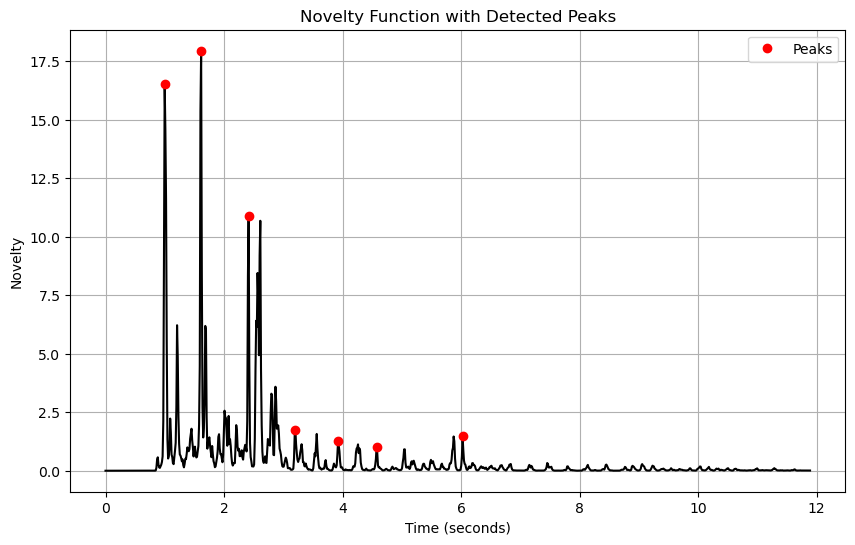

Detected peaks (segments):
Peak at 0.9985 seconds, Novelty value: 16.5101
Peak at 1.6138 seconds, Novelty value: 17.9492
Peak at 2.4149 seconds, Novelty value: 10.8918
Peak at 3.2044 seconds, Novelty value: 1.7269
Peak at 3.9242 seconds, Novelty value: 1.2818
Peak at 4.5743 seconds, Novelty value: 1.0106
Peak at 6.0256 seconds, Novelty value: 1.4668


In [77]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming the `compute_novelty_ssm` function is defined as in the prompt (adjusted as necessary)
def compute_novelty_ssm(S, kernel=None, L=10, var=0.5, exclude=False):
    """Compute novelty function from SSM [FMP, Section 4.4.1]

    Args:
        S (np.ndarray): SSM (spectral similarity matrix)
        kernel (np.ndarray): Checkerboard kernel (if kernel==None, it will be computed)
        L (int): Parameter specifying the kernel size M=2*L+1
        var (float): Variance parameter determining the tapering (epsilon)
        exclude (bool): Sets the first L and last L values of novelty function to zero

    Returns:
        nov (np.ndarray): Novelty function
    """
    if kernel is None:
        kernel = compute_kernel_checkerboard_gaussian(L=L, var=var)
    N = S.shape[0]
    M = 2 * L + 1
    nov = np.zeros(N)
    S_padded = np.pad(S, L, mode='constant')

    for n in range(N):
        nov[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)
    if exclude:
        right = np.min([L, N])
        left = np.max([0, N-L])
        nov[0:right] = 0
        nov[left:N] = 0

    return nov

def compute_kernel_checkerboard_gaussian(L=10, var=0.5):
    """Compute the checkerboard kernel for the novelty function"""
    M = 2 * L + 1
    kernel = np.zeros((M, M))
    center = L
    for i in range(M):
        for j in range(M):
            dist = (i - center)**2 + (j - center)**2
            kernel[i, j] = np.exp(-dist / (2 * var))
    return kernel

# Load FLAC audio file using librosa
file_path = r"01. Vitalic.flac"  # Replace with your FLAC file path
y, sr = librosa.load(file_path, sr=None)  # `sr=None` to use the original sample rate

# Compute the spectrogram (using a STFT, for example)
D = librosa.stft(y)  # Short-Time Fourier Transform (STFT)
S = np.abs(D)  # Magnitude spectrogram

# Set kernel size and parameters
L_kernel = 20  # Kernel size parameter (adjust as necessary)
nov = compute_novelty_ssm(S, L=L_kernel, exclude=False)

# Detect peaks (segments) in the novelty function
peaks, _ = find_peaks(nov, height=0.5, distance=50)  # Adjust the threshold and distance as needed

# Convert the peak frames to seconds
hop_length = 512  # Typically, the default hop_length in librosa's stft is 512
peak_times = peaks * hop_length / sr  # Convert frames to seconds

# Plot the novelty function with time in seconds on the x-axis
plt.figure(figsize=(10, 6))
time_seconds = np.arange(len(nov)) * hop_length / sr  # Time values corresponding to each frame
plt.plot(time_seconds, nov, color='k')
plt.plot(peak_times, nov[peaks], 'ro', label='Peaks')
plt.title('Novelty Function with Detected Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Novelty')
plt.grid(True)
plt.legend()
plt.show()

# Print detected peaks (segments) in seconds
print("Detected peaks (segments):")
for i, peak in enumerate(peaks):
    print(f"Peak at {peak_times[i]:.4f} seconds, Novelty value: {nov[peak]:.4f}")


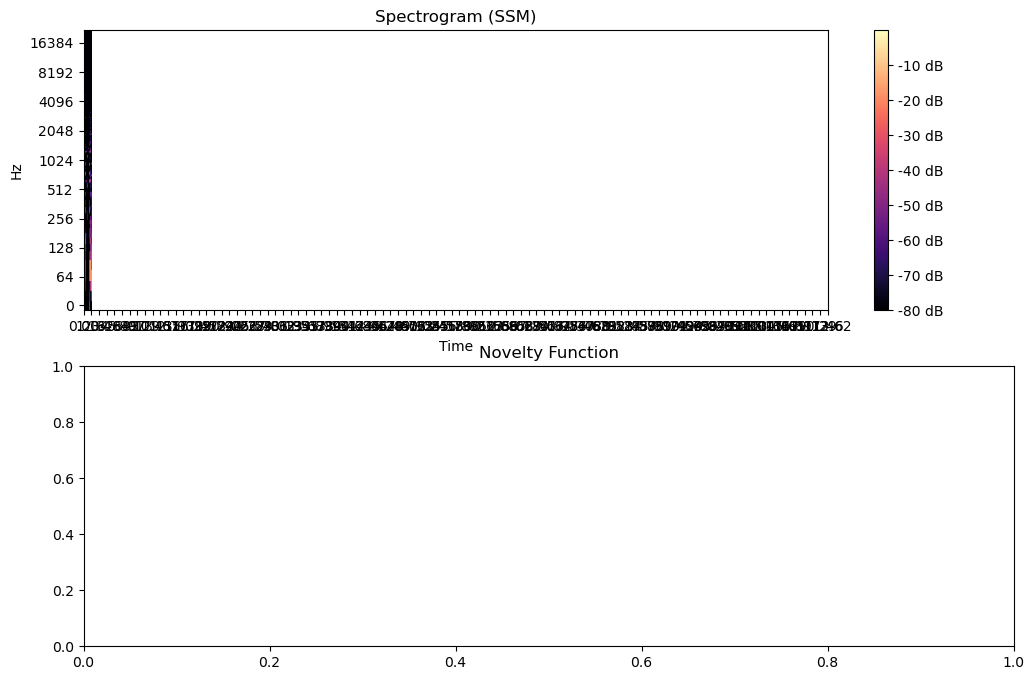

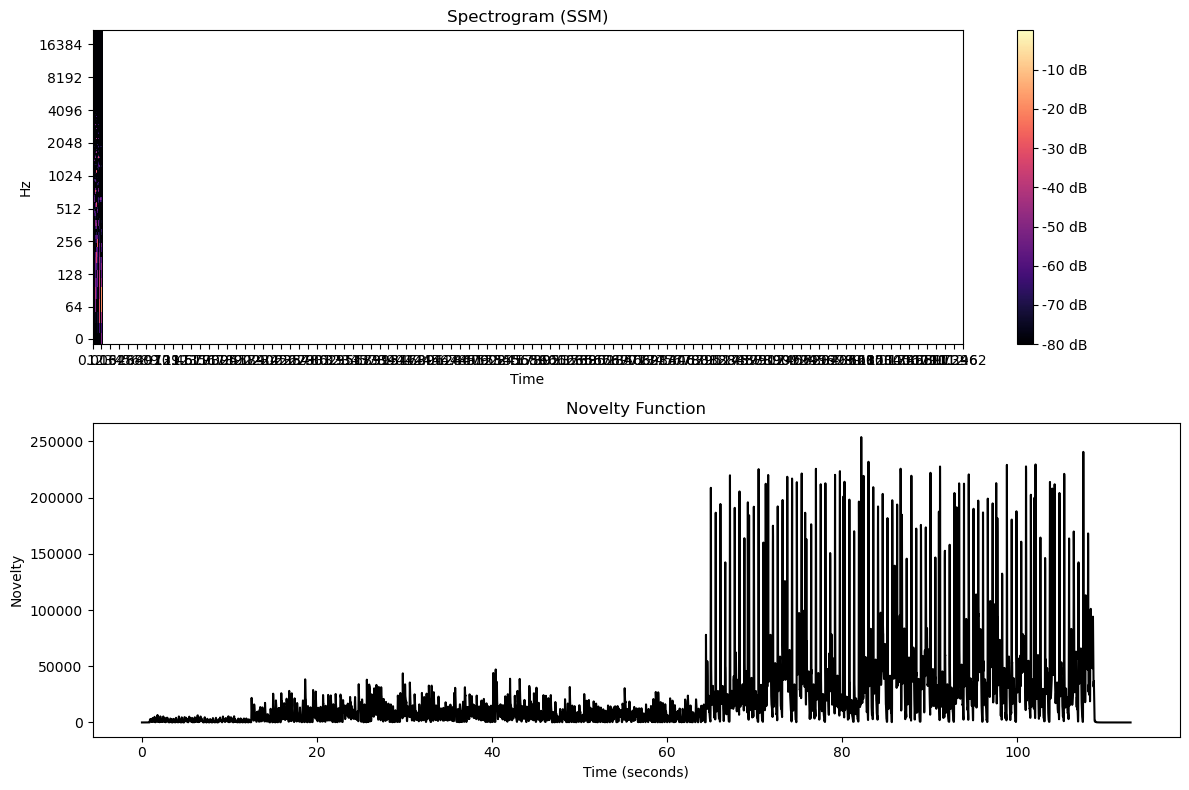

In [85]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Function to load a FLAC file and compute the SSM (Spectrogram)
def load_audio_and_compute_SSM(fpath, hop_length=512, n_fft=2048, win_length=None, window='hann'):
    # Load audio file
    audio, sr = librosa.load(fpath, sr=None, mono=True)  # sr=None preserves the original sampling rate

    # Compute the spectrogram (SSM)
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window))**2
    return S, sr, audio

# Compute novelty function
def compute_novelty_ssm(S, kernel=None, L=10, var=0.5, exclude=False):
    if kernel is None:
        kernel = compute_kernel_checkerboard_gaussian(L=L, var=var)
    N = S.shape[1]  # This should be the number of frames (columns)
    M = 2*L + 1
    nov = np.zeros(N)
    S_padded = np.pad(S, ((0, 0), (L, L)), mode='constant')  # Pad the S matrix along the time axis

    for n in range(N):
        # Compute novelty by applying the kernel over the relevant part of the spectrogram
        # Change this to apply a 1D kernel along the time axis (columns)
        nov[n] = np.sum(S_padded[:, n:n+M] * kernel)  # Apply kernel across time frames (column-wise)

    if exclude:
        right = np.min([L, N])
        left = np.max([0, N-L])
        nov[0:right] = 0
        nov[left:N] = 0

    return nov

# Function to create a Gaussian kernel for novelty computation
def compute_kernel_checkerboard_gaussian(L=20, var=0.5):
    # Create a simple 1D Gaussian kernel
    x = np.linspace(-L, L, 2 * L + 1)
    kernel = np.exp(-0.5 * (x / var) ** 2)
    kernel = kernel / np.sum(kernel)  # Normalize the kernel
    return kernel

# Load your FLAC file and compute the SSM
fpath = r'\01. Vitalic.flac'  # Replace with the path to your FLAC file
S, sr, audio = load_audio_and_compute_SSM(fpath)

# Compute novelty
L_kernel = 20
nov = compute_novelty_ssm(S, L=L_kernel, exclude=False)

# Calculate time vector for frames (in seconds)
hop_length = 512  # Use the hop_length used in STFT
time_per_frame = hop_length / sr  # Time per frame in seconds
time_vector = np.arange(S.shape[1]) * time_per_frame  # Time vector for the spectrogram

# Ensure novelty function matches the time vector length
time_vector_nov = np.arange(len(nov)) * time_per_frame  # Adjust time vector to match novelty length

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the spectrogram (SSM)
ax1.set_title('Spectrogram (SSM)')
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax1)
ax1.set_xticks(np.arange(0, S.shape[1], 100))  # Optional: to customize x-ticks
ax1.set_xticklabels([f'{i * time_per_frame:.2f}' for i in range(0, S.shape[1], 100)])  # Show time in seconds
fig.colorbar(img, ax=ax1, format='%+2.0f dB')

# Plot the novelty function
ax2.set_title('Novelty Function')
ax2.plot(time_vector_nov, nov, color='k')  # Use time_vector_nov for x-axis in seconds
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Novelty')

plt.tight_layout()
plt.show()
